In [23]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

csv_file = '/content/drive/My Drive/TFG_AlienEmbarecRiadi/hotel_bookings_str.csv'
df = pd.read_csv(csv_file, delimiter=',')

df.pop('arrival_year_week')
df.pop('agent')
print(df.head(10))

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  adults  children  babies meal country market_segment distribution_channel  is_repeated_guest  previous_cancellations  previous_bookings_not_canceled reserved_room_type assigned_room_type  booking_changes deposit_type  days_in_waiting_list customer_type    adr  required_car_parking_spaces  total_of_special_requests reservation_status reservation_status_date  total_stayed_nights  weekend_nights_proportion
0  Resort Hotel            0        342               2015               July                        27                          1                        0                     0       2         0       0   BB     PRT         Direct               Direct                  0                       0                               0                  C                  C                3   No Deposit                   

In [24]:
from math import *
import pandas as pd
import numpy as np

# import plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
#from pandas.plotting import scatter_matrix
%matplotlib inline
plt.style.use(['fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# pre-processing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer

# import libraries for model validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [25]:
df['kids'] = df.children + df.babies
df['total_members'] = df.kids + df.adults

In [26]:
df['arrival_date_year'] = df['arrival_date_year'].astype('str')
df['arrival_date_month'] = df['arrival_date_month'].astype('str')
df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].astype('str')
df['arrival_date'] = df['arrival_date_day_of_month'] + '-' + df['arrival_date_month'] + '-' + df['arrival_date_year']
df['arrival_date'] = pd.to_datetime(df['arrival_date'], errors='coerce')

In [27]:
# applying string methode to convert to categorical feature
df['is_canceled'] = df['is_canceled'].astype('str')
df['is_repeated_guest'] = df['is_repeated_guest'].astype('str')


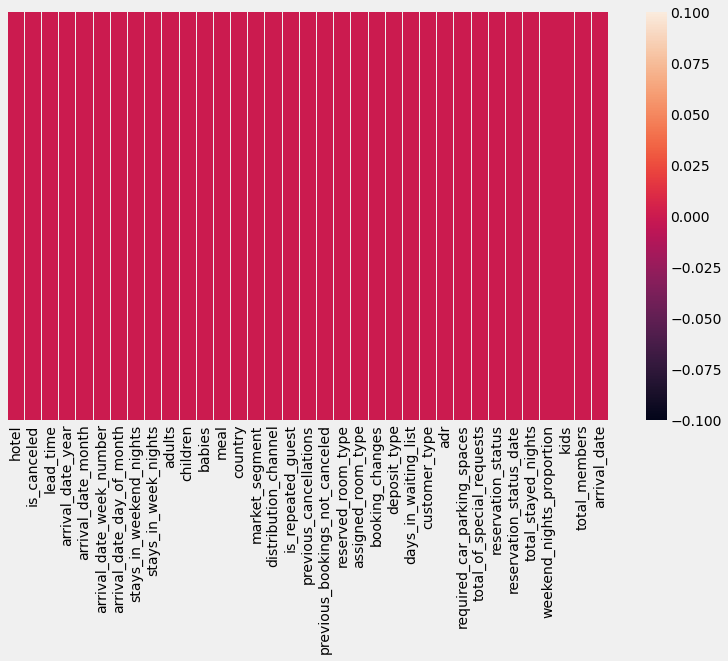

In [28]:
# Missing value visualization 
plt.figure(figsize=(12,7))
sns.heatmap(df.isnull(), yticklabels=False)
plt.show()


In [29]:
print(df.isnull().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [30]:
# Nuevo dataset
confirmed_bookings = df[df.is_canceled=='0']


In [31]:
import datetime as dt
confirmed_bookings['arrival_month'] = df['arrival_date'].dt.month
confirmed_bookings.arrival_month.value_counts().sort_index()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1     4122
2     5372
3     6645
4     6565
5     7114
6     6404
7     7919
8     8638
9     6392
10    6914
11    4672
12    4409
Name: arrival_month, dtype: int64

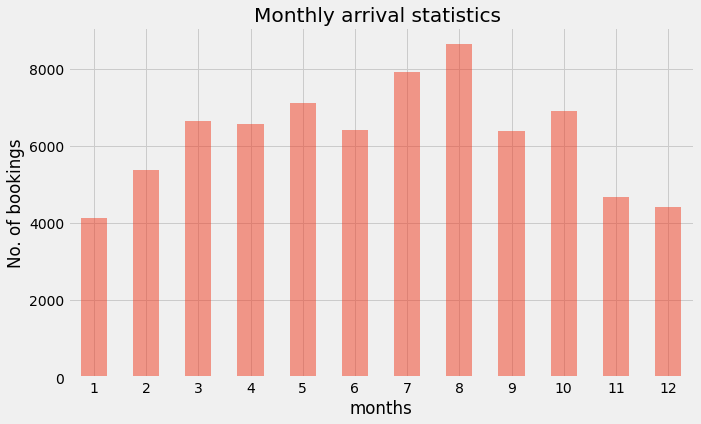

In [32]:
# Visualization of arrival on monthly basis for both types of hotels together
plt.figure(figsize=(12,5))
(confirmed_bookings.arrival_month.value_counts().sort_index()).plot(kind='bar',
                    figsize=(10,6), title = 'Monthly arrival statistics ', color='#f03b20', alpha=0.5)
plt.xlabel('months')
plt.ylabel('No. of bookings')
plt.xticks(rotation='horizontal')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


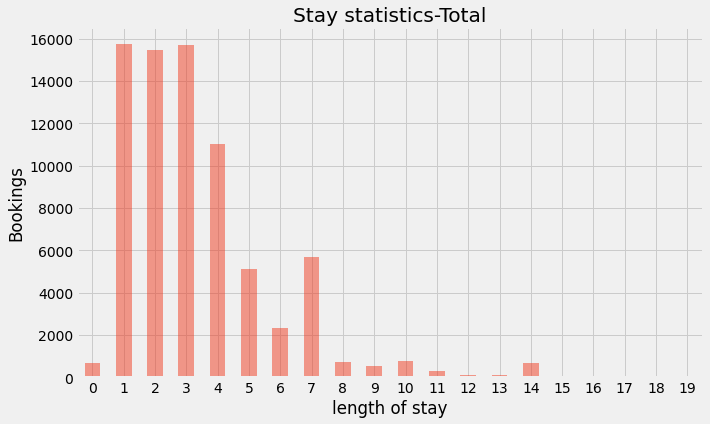

In [33]:
confirmed_bookings['total_span_of_stay'] = confirmed_bookings.stays_in_week_nights + confirmed_bookings.stays_in_weekend_nights
length_of_stay = confirmed_bookings.total_span_of_stay.value_counts().sort_index()
length_of_stay.head(20).plot(kind='bar', figsize=(10,6), title = 'length of stay', color='#f03b20', alpha=0.5)
plt.title('Stay statistics-Total')
plt.xlabel('length of stay')
plt.ylabel('Bookings')
plt.xticks(rotation='horizontal')
plt.show()


In [35]:
conf_book_city = confirmed_bookings[confirmed_bookings.hotel=='City Hotel']
conf_book_resort = confirmed_bookings[confirmed_bookings.hotel=='Resort Hotel']

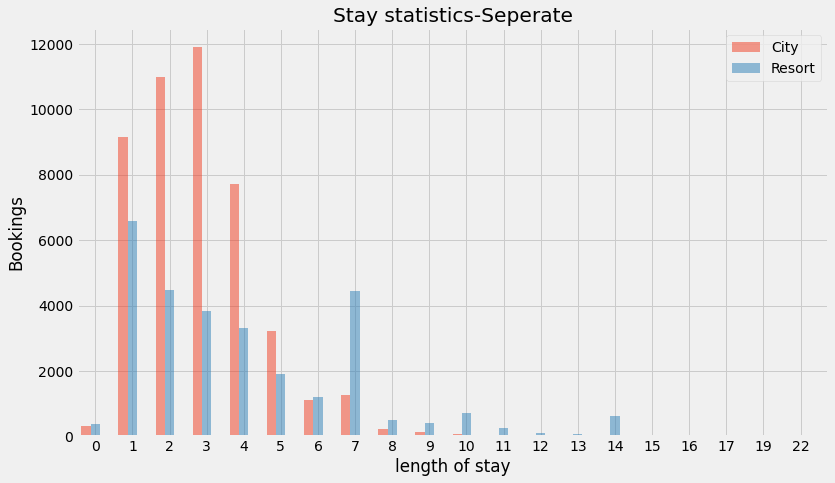

In [36]:
# Stay statistics based on type of hotel
city = conf_book_city.total_span_of_stay.value_counts().head(20).sort_index()
resort = conf_book_resort.total_span_of_stay.value_counts().head(20).sort_index()

position = list(range(len(city)))
width = 0.25

fig, ax = plt.subplots(figsize=(12,7))
plt.bar([p for p in position], city, width, alpha=0.5, color='#f03b20', label='City')
plt.bar([p+width for p in position], resort, width, alpha=0.5, color='#2c7fb8', label='Resort')

ax.set_xticks([p + width for p in position])
ax.set_xticklabels(city.index)
plt.xlim(min(position)-width, max(position)+width*4)
plt.title('Stay statistics-Seperate')
plt.xlabel('length of stay')
plt.ylabel('Bookings')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

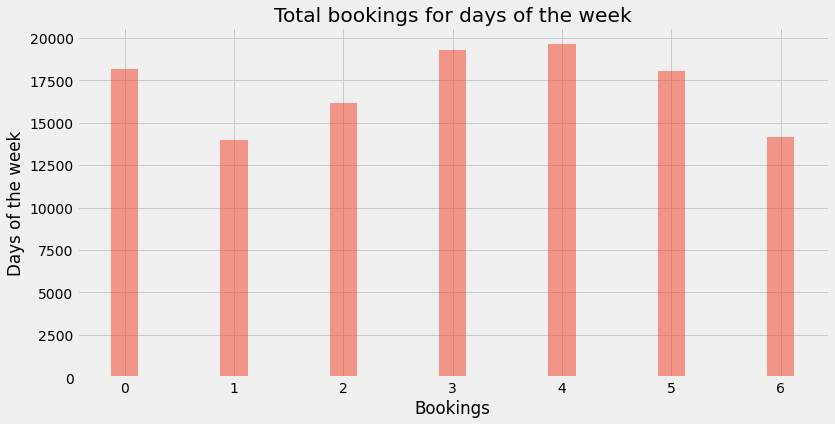

In [38]:
weekday = df.arrival_date.dt.weekday.value_counts().sort_index()

position = list(range(len(weekday))) 
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(position, weekday, width, alpha=0.5, color='#f03b20', label='Cancelled Bookings')

ax.set_xticks([p for p in position])
ax.set_xticklabels(city.index)
ax.set_title('Total bookings for days of the week')
ax.set_xlabel('Bookings')
ax.set_ylabel('Days of the week')
plt.show()

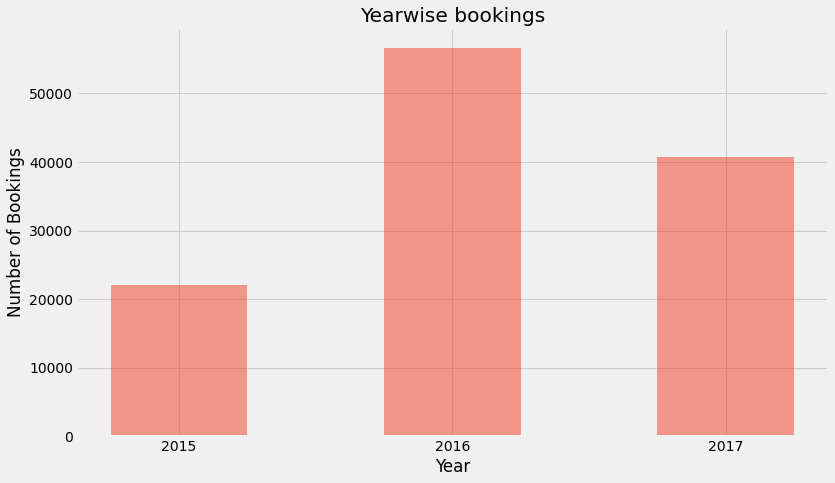

In [40]:
year = df.arrival_date.dt.year.value_counts().sort_index()
position = list(range(len(year))) 

fig, ax = plt.subplots(figsize=(12,7))
plt.bar(position, year, width=.50, alpha=0.5, color='#f03b20', label=year.index[0])

ax.set_xticks([p for p in position])
ax.set_xticklabels(year.index)
plt.title('Yearwise bookings')
plt.xlabel('Year')
plt.ylabel('Number of Bookings')
plt.show()

In [41]:
# Creating dataframe for price distribution
confirmed_bookings['total_legit_members'] = confirmed_bookings.adults + confirmed_bookings.children
confirmed_bookings_copy = confirmed_bookings.drop(index=confirmed_bookings.loc[confirmed_bookings.total_legit_members==0].index, axis=0)
confirmed_bookings_copy['price_night_person'] = confirmed_bookings_copy.adr/confirmed_bookings_copy.total_legit_members
prices = confirmed_bookings_copy[['hotel', 'reserved_room_type', 'price_night_person']].sort_values('reserved_room_type')
prices.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,hotel,reserved_room_type,price_night_person
119389,City Hotel,A,75.60
102432,City Hotel,A,89.55
77019,City Hotel,A,53.00
77020,City Hotel,A,53.00
77021,City Hotel,A,50.40


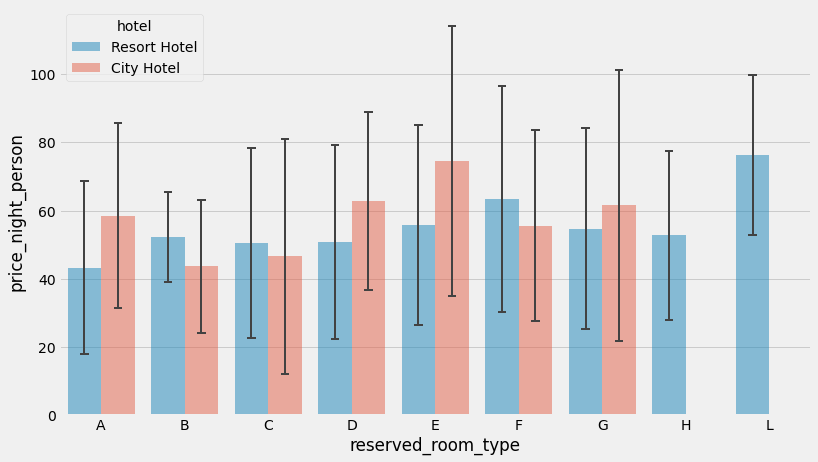

In [42]:
# Visualizing the price distribution
plt.figure(figsize=(12,7))
sns.barplot(x=confirmed_bookings_copy.reserved_room_type.sort_values(), y='price_night_person', hue='hotel', 
            data=confirmed_bookings_copy, alpha=0.5, ci='sd', errwidth=2, capsize=0.1)
plt.show()

In [45]:
numerical = [var for var in df.columns if df[var].dtypes!='object']
numerical


['lead_time',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_stayed_nights',
 'weekend_nights_proportion',
 'kids',
 'total_members',
 'arrival_date']

In [46]:
for j in numerical:
    IQR = df[j].quantile(0.75) - df[j].quantile(0.25)
    Lower_fence = df[j].quantile(0.25) - (IQR * 3)
    Upper_fence = df[j].quantile(0.75) + (IQR * 3)
    print(j + ' outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


lead_time outliers are values < -408.0 or > 586.0
arrival_date_week_number outliers are values < -50.0 or > 104.0
stays_in_weekend_nights outliers are values < -6.0 or > 8.0
stays_in_week_nights outliers are values < -5.0 or > 9.0
adults outliers are values < 2.0 or > 2.0
children outliers are values < 0.0 or > 0.0
babies outliers are values < 0.0 or > 0.0
previous_cancellations outliers are values < 0.0 or > 0.0
previous_bookings_not_canceled outliers are values < 0.0 or > 0.0
booking_changes outliers are values < 0.0 or > 0.0
days_in_waiting_list outliers are values < 0.0 or > 0.0
adr outliers are values < -100.83999999999999 or > 296.13
required_car_parking_spaces outliers are values < 0.0 or > 0.0
total_of_special_requests outliers are values < -3.0 or > 4.0
total_stayed_nights outliers are values < -4.0 or > 10.0
weekend_nights_proportion outliers are values < -120.0 or > 160.0
kids outliers are values < 0.0 or > 0.0
total_members outliers are values < 2.0 or > 2.0
arrival_date ou

In [48]:
for k in numerical:
    print("the min and max values of " + k + " are {} and {}".format(df[k].min(), df[k].max()))

the min and max values of lead_time are 0 and 737
the min and max values of arrival_date_week_number are 1 and 53
the min and max values of stays_in_weekend_nights are 0 and 19
the min and max values of stays_in_week_nights are 0 and 50
the min and max values of adults are 0 and 55
the min and max values of children are 0 and 10
the min and max values of babies are 0 and 10
the min and max values of previous_cancellations are 0 and 26
the min and max values of previous_bookings_not_canceled are 0 and 72
the min and max values of booking_changes are 0 and 21
the min and max values of days_in_waiting_list are 0 and 391
the min and max values of adr are -6.38 and 5400.0
the min and max values of required_car_parking_spaces are 0 and 8
the min and max values of total_of_special_requests are 0 and 5
the min and max values of total_stayed_nights are 0 and 69
the min and max values of weekend_nights_proportion are 0.0 and 100.0
the min and max values of kids are 0 and 10
the min and max value

In [49]:
def max_value(bookings, variable, top):
    return np.where(bookings[variable]>top, top, bookings[variable])
df['lead_time'] = max_value(df,'lead_time',586)
df['stays_in_weekend_nights'] = max_value(df,'stays_in_weekend_nights',8)
df['stays_in_week_nights'] = max_value(df,'stays_in_week_nights',9)
df['adults'] = max_value(df,'adults',2)
df['previous_cancellations'] = max_value(df,'previous_cancellations',0)
df['previous_bookings_not_canceled'] = max_value(df,'previous_bookings_not_canceled',0)
df['booking_changes'] = max_value(df,'booking_changes',0)
df['days_in_waiting_list'] = max_value(df,'days_in_waiting_list',0)
df['adr'] = max_value(df,'adr',296.13)
df['required_car_parking_spaces'] = max_value(df,'required_car_parking_spaces',0)
df['total_of_special_requests'] = max_value(df,'total_of_special_requests',4)
df['kids'] = max_value(df,'kids',0)   

NameError: ignored